# Handling Missing Values in Pandas

This notebook is a step-by-step tutorial for **beginners in data analytics with Python**. You will learn what missing values are, how to detect them, and several practical ways to handle them using the pandas library.

We will use a small sensor dataset called `sensor_log.csv` as a running example.

### Learning goals
By the end of this notebook you should be able to:
- Explain what a missing value is and why it matters.
- Load data into a pandas DataFrame and check for missing values.
- Summarise how many missing values each column has.
- Decide when to drop rows or columns that contain missing values.
- Fill (impute) missing values using simple strategies such as constants, mean, median, and forward or backward fill.
- Understand the advantages and disadvantages of each approach.


## 0. Setup

We start by importing the main Python libraries we will use:

- `pandas` for working with tabular data (tables).
- `numpy` for working with numeric values such as the special `NaN` value that represents "Not a Number".


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ All libraries imported successfully!")

# Optional: show the pandas version so students know which version is used
print('pandas version:', pd.__version__)


✓ All libraries imported successfully!
pandas version: 2.3.3


## 1. Loading the dataset and taking a first look

Our example dataset `sensor_log.csv` contains readings from a temperature and humidity sensor. Each row is one measurement.

Typical steps when you first load a dataset are:
- Look at the first few rows with `head`.
- Check the shape (how many rows and columns).
- Look at basic information about each column with `info`.


In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv('sensor_log.csv')

# Look at the first 5 rows
df.head()


,timestamp,temperature_c,humidity_pct,voltage_v
0,2025-10-01 08:00:00,24.5,55.2,3.70
1,2025-10-01 08:00:10,24.7,55.0,3.69
2,2025-10-01 08:00:20,24.6,55.1,NaN
3,2025-10-01 08:00:30,NaN,54.9,3.68
4,2025-10-01 08:01:00,24.9,54.8,3.68


In [3]:
# How many rows and columns does the dataset have?
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])

# General information about the DataFrame, including data types and non-null counts
df.info()


Number of rows: 10
Number of columns: 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      10 non-null     object 
 1   temperature_c  8 non-null      float64
 2   humidity_pct   9 non-null      float64
 3   voltage_v      9 non-null      float64
dtypes: float64(3), object(1)
memory usage: 452.0+ bytes


### What is a missing value?

In real-world data, we often do not have every value for every row. For example:
- A sensor might temporarily fail to record a value.
- A user might skip a question in a survey.
- A value might be invalid or lost during data collection.

In pandas, missing numeric values are usually represented as `NaN` (Not a Number). In some datasets, missing values may also be shown as special codes such as -999 or the string 'NA'. We can convert those to proper missing values if needed.


## 2. Detecting missing values

The first step in handling missing data is **finding out where the missing values are**.

Useful pandas functions:
- `isna()` or `isnull()` return `True` where a value is missing.
- `notna()` or `notnull()` return `True` where a value is present.

We rarely look at the full `True`/`False` table. Instead, we usually sum up how many missing values are in each column.


In [4]:
# A quick look at where values are missing (True means missing)
df.isna().head()


,timestamp,temperature_c,humidity_pct,voltage_v
0,False,False,False,False
1,False,False,False,False
2,False,False,False,True
3,False,True,False,False
4,False,False,False,False


In [5]:
# Count how many missing values are in each column
df.isna().sum()


timestamp        0
temperature_c    2
humidity_pct     1
voltage_v        1
dtype: int64

In [6]:
# Calculate the percentage of missing values in each column
missing_percent = df.isna().mean() * 100
missing_percent.round(2)


timestamp         0.0
temperature_c    20.0
humidity_pct     10.0
voltage_v        10.0
dtype: float64

### Exercise 1 (for students)

1. Create a new Series or DataFrame that shows only the rows where `temperature_c` is missing.
2. Do the same for `humidity_pct`.
3. Which column in this dataset has the highest percentage of missing values?


In [8]:
# ============================================================================
# QUESTION 1: Show rows where temperature_c is missing
# ============================================================================
print("\n" + "="*70)
print("QUESTION 1: Rows where temperature_c is missing")
print("="*70)

# Create a Series/DataFrame showing only rows where temperature_c is missing
temp_missing_rows = df[df['temperature_c'].isnull()]

print(f"\nNumber of rows with missing temperature_c: {len(temp_missing_rows)}")
print("\nRows where temperature_c is missing:")
print(temp_missing_rows)

# Save as a new DataFrame
temp_missing_df = temp_missing_rows.copy()
print(f"\n✓ Created DataFrame: temp_missing_df with {len(temp_missing_df)} rows")



QUESTION 1: Rows where temperature_c is missing

Number of rows with missing temperature_c: 2

Rows where temperature_c is missing:
             timestamp  temperature_c  humidity_pct  voltage_v
3  2025-10-01 08:00:30            NaN          54.9       3.68
8  2025-10-01 08:08:00            NaN          55.0       3.64

✓ Created DataFrame: temp_missing_df with 2 rows


In [9]:
# ============================================================================
# QUESTION 2: Show rows where humidity_pct is missing
# ============================================================================
print("\n" + "="*70)
print("QUESTION 2: Rows where humidity_pct is missing")
print("="*70)

# Create a Series/DataFrame showing only rows where humidity_pct is missing
humidity_missing_rows = df[df['humidity_pct'].isnull()]

print(f"\nNumber of rows with missing humidity_pct: {len(humidity_missing_rows)}")
print("\nRows where humidity_pct is missing:")
print(humidity_missing_rows)

# Save as a new DataFrame
humidity_missing_df = humidity_missing_rows.copy()
print(f"\n✓ Created DataFrame: humidity_missing_df with {len(humidity_missing_df)} rows")


QUESTION 2: Rows where humidity_pct is missing

Number of rows with missing humidity_pct: 1

Rows where humidity_pct is missing:
             timestamp  temperature_c  humidity_pct  voltage_v
5  2025-10-01 08:02:15           25.1           NaN       3.67

✓ Created DataFrame: humidity_missing_df with 1 rows


In [10]:
# ============================================================================
# QUESTION 3: Which column has the highest percentage of missing values?
# ============================================================================
print("\n" + "="*70)
print("QUESTION 3: Column with highest percentage of missing values")
print("="*70)

# Calculate missing values count for each column
missing_count = df.isnull().sum()

# Calculate percentage of missing values for each column
total_rows = len(df)
missing_percentage = (missing_count / total_rows) * 100

# Create a summary DataFrame
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': missing_count.values,
    'Missing Percentage': missing_percentage.values
})

# Sort by missing percentage (highest first)
missing_summary = missing_summary.sort_values('Missing Percentage', ascending=False)

print("\nMissing Values Summary:")
print(missing_summary.to_string(index=False))

# Find the column with highest percentage
highest_missing_column = missing_summary.iloc[0]['Column']
highest_missing_pct = missing_summary.iloc[0]['Missing Percentage']

print("\n" + "-"*70)
print(f" ANSWER: The column with the highest percentage of missing values is:")
print(f"   Column: {highest_missing_column}")
print(f"   Missing: {missing_summary.iloc[0]['Missing Count']:.0f} out of {total_rows} rows")
print(f"   Percentage: {highest_missing_pct:.2f}%")
print("-"*70)


QUESTION 3: Column with highest percentage of missing values

Missing Values Summary:
       Column  Missing Count  Missing Percentage
temperature_c              2                20.0
 humidity_pct              1                10.0
    voltage_v              1                10.0
    timestamp              0                 0.0

----------------------------------------------------------------------
 ANSWER: The column with the highest percentage of missing values is:
   Column: temperature_c
   Missing: 2 out of 10 rows
   Percentage: 20.00%
----------------------------------------------------------------------


## 3. Strategy 1: Dropping missing values

The simplest strategy is to **remove** rows or columns that contain missing values.

- `dropna()` by default drops any row that has at least one missing value.
- You can also drop columns instead of rows (by using `axis=1` or `axis='columns'`).

This can be safe if:
- Only a small number of rows are missing.
- The rows are not systematically different from the others.

It can be dangerous if you lose a lot of data, or if the missingness is not random.


In [11]:
# Drop any rows that contain at least one missing value
df_drop_rows = df.dropna()

print('Original shape:', df.shape)
print('After dropping rows with any missing values:', df_drop_rows.shape)
df_drop_rows.head()


Original shape: (10, 4)
After dropping rows with any missing values: (6, 4)


,timestamp,temperature_c,humidity_pct,voltage_v
0,2025-10-01 08:00:00,24.5,55.2,3.70
1,2025-10-01 08:00:10,24.7,55.0,3.69
4,2025-10-01 08:01:00,24.9,54.8,3.68
6,2025-10-01 08:03:00,25.3,54.7,3.67
7,2025-10-01 08:05:30,25.5,54.9,3.65


In [12]:
# Drop columns that contain any missing values
df_drop_cols = df.dropna(axis='columns')

print('Columns before:', df.columns.tolist())
print('Columns after dropping any column with missing values:', df_drop_cols.columns.tolist())
df_drop_cols.head()


Columns before: ['timestamp', 'temperature_c', 'humidity_pct', 'voltage_v']
Columns after dropping any column with missing values: ['timestamp']


,timestamp
0,2025-10-01 08:00:00
1,2025-10-01 08:00:10
2,2025-10-01 08:00:20
3,2025-10-01 08:00:30
4,2025-10-01 08:01:00


### When is dropping okay?

Dropping rows or columns with missing values may be acceptable when:
- The percentage of missing values is very small.
- You are sure that losing those rows will not bias your analysis.

However, if you drop too much data, your results may no longer represent the real situation. In those cases, filling the missing values may be better.


## 4. Strategy 2: Filling missing values with simple rules

Instead of removing data, we can **fill in** missing values with reasonable guesses. This process is called *imputation*.

Common simple strategies:
- Fill with a fixed constant (for example 0 or a special code).
- Fill numeric columns with the column mean or median.
- For categorical columns (for example city or category), fill with the most frequent value (the mode).

In pandas we usually use the `fillna` function for this.


In [13]:
# Example: fill missing voltage values with a constant
df_constant = df.copy()

df_constant['voltage_v'] = df_constant['voltage_v'].fillna(0)

df_constant.head()


,timestamp,temperature_c,humidity_pct,voltage_v
0,2025-10-01 08:00:00,24.5,55.2,3.70
1,2025-10-01 08:00:10,24.7,55.0,3.69
2,2025-10-01 08:00:20,24.6,55.1,0.00
3,2025-10-01 08:00:30,NaN,54.9,3.68
4,2025-10-01 08:01:00,24.9,54.8,3.68


In [14]:
# Fill all numeric columns with their column mean
df_mean = df.copy()
numeric_cols = df_mean.select_dtypes(include='number').columns

for col in numeric_cols:
    col_mean = df_mean[col].mean()
    df_mean[col] = df_mean[col].fillna(col_mean)

df_mean.head()


,timestamp,temperature_c,humidity_pct,voltage_v
0,2025-10-01 08:00:00,24.500,55.2,3.700000
1,2025-10-01 08:00:10,24.700,55.0,3.690000
2,2025-10-01 08:00:20,24.600,55.1,3.667778
3,2025-10-01 08:00:30,25.075,54.9,3.680000
4,2025-10-01 08:01:00,24.900,54.8,3.680000


In [15]:
# Check that there are no missing values left in the numeric columns
df_mean[numeric_cols].isna().sum()


temperature_c    0
humidity_pct     0
voltage_v        0
dtype: int64

In [16]:
# (Optional) Example with a small categorical column
example = pd.DataFrame({
    'city': ['Accra', 'Accra', 'Kumasi', np.nan, 'Accra'],
    'temperature_c': [30, 31, 29, 28, np.nan]
})

print('Original example DataFrame:')
display(example)

# Fill missing city with the most frequent city (the mode)
city_mode = example['city'].mode()[0]
example['city'] = example['city'].fillna(city_mode)

# Fill missing temperature with the median
temp_median = example['temperature_c'].median()
example['temperature_c'] = example['temperature_c'].fillna(temp_median)

print('After filling missing values:')
display(example)


Original example DataFrame:


,city,temperature_c
0,Accra,30.0
1,Accra,31.0
2,Kumasi,29.0
3,NaN,28.0
4,Accra,NaN


After filling missing values:


,city,temperature_c
0,Accra,30.0
1,Accra,31.0
2,Kumasi,29.0
3,Accra,28.0
4,Accra,29.5


### Exercise 2 (for students)

1. Create a copy of `df` called `df_median`.
2. For each numeric column, fill the missing values with the column median.
3. Compare the results of mean-based imputation (`df_mean`) and median-based imputation (`df_median`). Which do you think is more robust to extreme values (outliers)?


In [17]:
# ============================================================================
# QUESTION 1: Create df_median (copy of df)
# ============================================================================
print("\n" + "="*70)
print("QUESTION 1: Creating df_median")
print("="*70)

df_median = df.copy()
print("✓ Created df_median as a copy of df")


QUESTION 1: Creating df_median
✓ Created df_median as a copy of df


In [18]:
# ============================================================================
# QUESTION 2: Fill missing values with MEDIAN
# ============================================================================
print("\n" + "="*70)
print("QUESTION 2: Filling missing values with MEDIAN")
print("="*70)

print("\nCalculating median for each numeric column:")
print("-"*70)

for column in df_median.columns:
    if df_median[column].dtype in ['float64', 'int64']:  # Only numeric columns
        median_value = df_median[column].median()
        missing_count = df_median[column].isnull().sum()
        
        if missing_count > 0:
            df_median[column].fillna(median_value, inplace=True)
            print(f"✓ {column}: Median = {median_value:.3f} (filled {missing_count} missing values)")
        else:
            print(f"  {column}: Median = {median_value:.3f} (no missing values)")

print("\nData after Median Imputation:")
print(df_median)

# Save to CSV
df_median.to_csv('data_median.csv', index=False)
print("\n✓ Saved as: data_median.csv")

# ============================================================================
# CREATE MEAN IMPUTATION FOR COMPARISON
# ============================================================================
print("\n" + "="*70)
print("Creating df_mean for comparison")
print("="*70)

df_mean = df.copy()

print("\nCalculating mean for each numeric column:")
print("-"*70)

for column in df_mean.columns:
    if df_mean[column].dtype in ['float64', 'int64']:  # Only numeric columns
        mean_value = df_mean[column].mean()
        missing_count = df_mean[column].isnull().sum()
        
        if missing_count > 0:
            df_mean[column].fillna(mean_value, inplace=True)
            print(f"✓ {column}: Mean = {mean_value:.3f} (filled {missing_count} missing values)")
        else:
            print(f"  {column}: Mean = {mean_value:.3f} (no missing values)")

print("\nData after Mean Imputation:")
print(df_mean)

# Save to CSV
df_mean.to_csv('data_mean.csv', index=False)
print("\n✓ Saved as: data_mean.csv")


QUESTION 2: Filling missing values with MEDIAN

Calculating median for each numeric column:
----------------------------------------------------------------------
✓ temperature_c: Median = 25.000 (filled 2 missing values)
✓ humidity_pct: Median = 55.000 (filled 1 missing values)
✓ voltage_v: Median = 3.670 (filled 1 missing values)

Data after Median Imputation:
             timestamp  temperature_c  humidity_pct  voltage_v
0  2025-10-01 08:00:00           24.5          55.2       3.70
1  2025-10-01 08:00:10           24.7          55.0       3.69
2  2025-10-01 08:00:20           24.6          55.1       3.67
3  2025-10-01 08:00:30           25.0          54.9       3.68
4  2025-10-01 08:01:00           24.9          54.8       3.68
5  2025-10-01 08:02:15           25.1          55.0       3.67
6  2025-10-01 08:03:00           25.3          54.7       3.67
7  2025-10-01 08:05:30           25.5          54.9       3.65
8  2025-10-01 08:08:00           25.0          55.0       3.64
9  2

C:\Users\mante\AppData\Local\Temp\ipykernel_3488\2205832976.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_median[column].fillna(median_value, inplace=True)
C:\Users\mante\AppData\Local\Temp\ipykernel_3488\2205832976.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [20]:
# ============================================================================
# QUESTION 3: COMPARISON - Mean vs Median
# ============================================================================
print("\n" + "="*70)
print("QUESTION 3: COMPARISON - Mean vs Median Imputation")
print("="*70)

# Get the rows that originally had missing values
missing_rows_idx = df[df.isnull().any(axis=1)].index

print("\n Comparison of filled values for rows with missing data:")
print("="*70)

for idx in missing_rows_idx:
    print(f"\nRow {idx}:")
    print(f"  Original: {df.iloc[idx].values}")
    print(f"  Mean:     {df_mean.iloc[idx].values}")
    print(f"  Median:   {df_median.iloc[idx].values}")

# Create a detailed comparison table
print("\n" + "="*70)
print("DETAILED COMPARISON TABLE: Mean vs Median")
print("="*70)

comparison_data = []
for column in df.select_dtypes(include=[np.number]).columns:
    mean_val = df[column].mean()
    median_val = df[column].median()
    std_val = df[column].std()
    min_val = df[column].min()
    max_val = df[column].max()
    difference = mean_val - median_val
    
    comparison_data.append({
        'Column': column,
        'Mean': round(mean_val, 3),
        'Median': round(median_val, 3),
        'Difference': round(difference, 3),
        'Std Dev': round(std_val, 3),
        'Min': round(min_val, 3),
        'Max': round(max_val, 3)
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))


QUESTION 3: COMPARISON - Mean vs Median Imputation

 Comparison of filled values for rows with missing data:

Row 2:
  Original: ['2025-10-01 08:00:20' np.float64(24.6) np.float64(55.1) np.float64(nan)]
  Mean:     ['2025-10-01 08:00:20' np.float64(24.6) np.float64(55.1)
 np.float64(3.6677777777777782)]
  Median:   ['2025-10-01 08:00:20' np.float64(24.6) np.float64(55.1) np.float64(3.67)]

Row 3:
  Original: ['2025-10-01 08:00:30' np.float64(nan) np.float64(54.9) np.float64(3.68)]
  Mean:     ['2025-10-01 08:00:30' np.float64(25.075000000000003) np.float64(54.9)
 np.float64(3.68)]
  Median:   ['2025-10-01 08:00:30' np.float64(25.0) np.float64(54.9) np.float64(3.68)]

Row 5:
  Original: ['2025-10-01 08:02:15' np.float64(25.1) np.float64(nan) np.float64(3.67)]
  Mean:     ['2025-10-01 08:02:15' np.float64(25.1) np.float64(54.96666666666667)
 np.float64(3.67)]
  Median:   ['2025-10-01 08:02:15' np.float64(25.1) np.float64(55.0) np.float64(3.67)]

Row 8:
  Original: ['2025-10-01 08:08:00'


VISUALIZATION: Mean vs Median Comparison


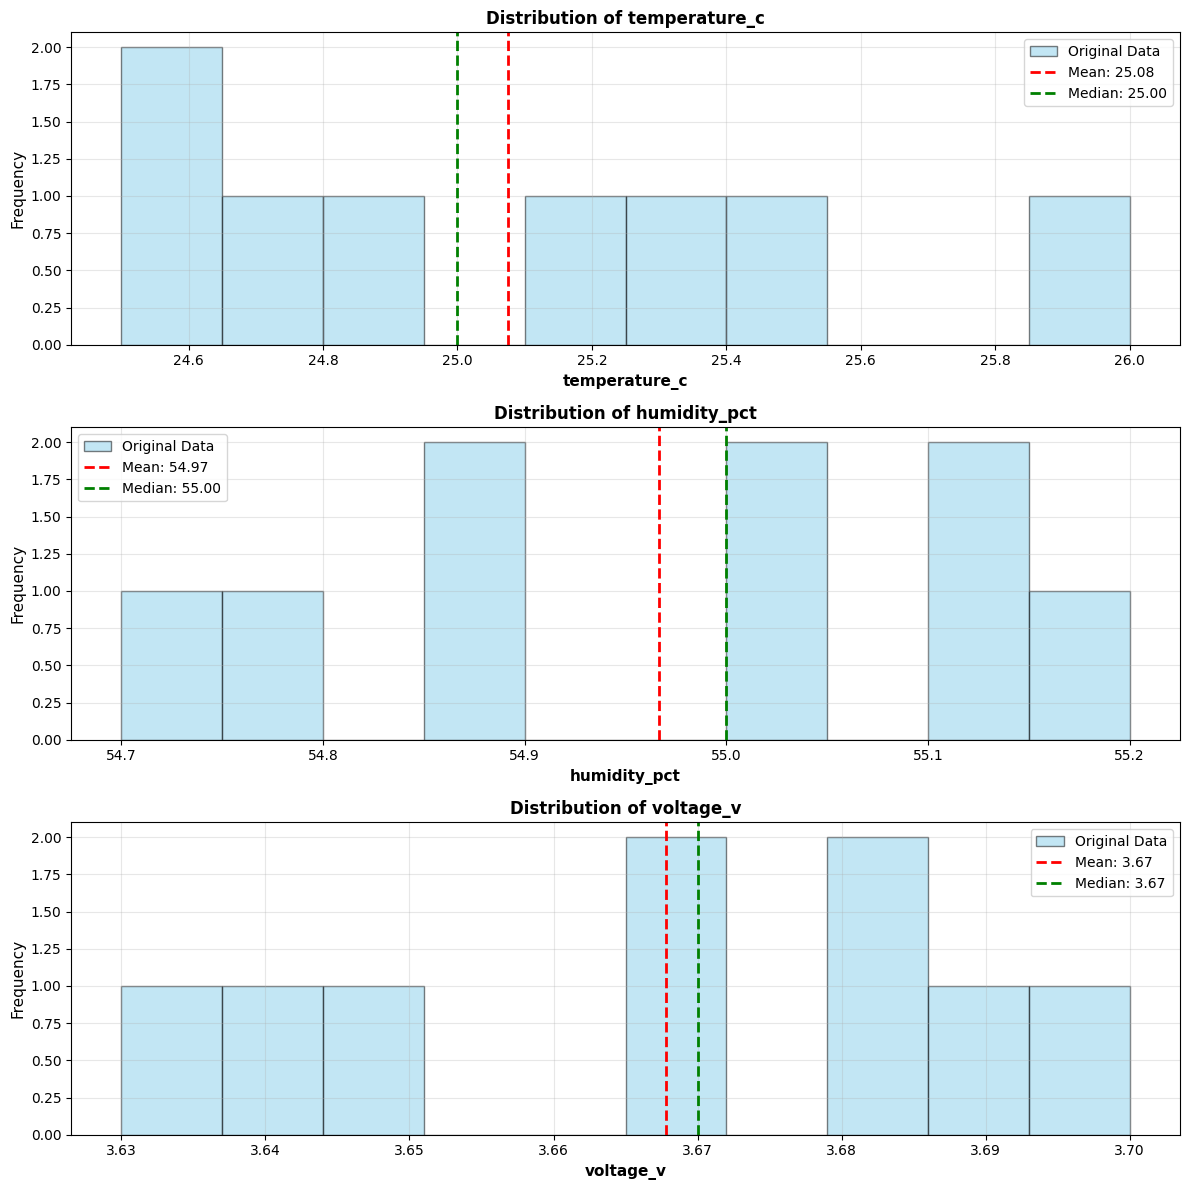

✓ Saved visualization as: mean_vs_median_comparison.png


In [23]:
# ============================================================================
# VISUALIZATION: Mean vs Median
# ============================================================================
print("\n" + "="*70)
print("VISUALIZATION: Mean vs Median Comparison")
print("="*70)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(12, 4*len(numeric_cols)))

if len(numeric_cols) == 1:
    axes = [axes]

for idx, column in enumerate(numeric_cols):
    # Plot original data with mean and median lines
    axes[idx].hist(df[column].dropna(), bins=10, alpha=0.5, color='skyblue', 
                   edgecolor='black', label='Original Data')
    
    mean_val = df[column].mean()
    median_val = df[column].median()
    
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                      label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, 
                      label=f'Median: {median_val:.2f}')
    
    axes[idx].set_xlabel(column, fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'Distribution of {column}', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mean_vs_median_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved visualization as: mean_vs_median_comparison.png")

In [25]:
# ============================================================================
# ANALYSIS: Which is more robust to outliers?
# ============================================================================
print("\n" + "="*70)
print("ANALYSIS: Mean vs Median Robustness to Outliers")
print("="*70)

print("\n EXPLANATION:")
print("-"*70)
print("""
MEAN (Average):
  • Calculated by: Sum of all values ÷ Number of values
  • Sensitive to OUTLIERS (extreme values)
  • If there's an extremely high or low value, the mean shifts toward it
  • Example: [1, 2, 3, 4, 100] → Mean = 22 (pulled up by 100)

MEDIAN (Middle value):
  • The middle value when data is sorted
  • ROBUST to outliers (not affected by extreme values)
  • Only cares about the middle position, not actual extreme values
  • Example: [1, 2, 3, 4, 100] → Median = 3 (stays in the middle)

WHICH IS MORE ROBUST TO OUTLIERS?
   MEDIAN is MORE ROBUST to extreme values/outliers
  
  Reasons:
  1. Median only looks at position, not magnitude
  2. One extreme value doesn't change the median much
  3. Mean gets "pulled" toward outliers
  4. Median is the preferred choice when outliers are present
""")

# Check if data has potential outliers
print("\n OUTLIER DETECTION (IQR Method):")
print("-"*70)

for column in numeric_cols:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    outlier_count = len(outliers)
    
    mean_val = df[column].mean()
    median_val = df[column].median()
    mean_median_diff = abs(mean_val - median_val)
    
    print(f"\n{column}:")
    print(f"  Outliers detected: {outlier_count}")
    print(f"  Mean: {mean_val:.3f}")
    print(f"  Median: {median_val:.3f}")
    print(f"  Difference: {mean_median_diff:.3f}")
    
    if outlier_count > 0:
        print(f"   Contains outliers → MEDIAN is more appropriate")
    else:
        print(f"  ✓ No outliers detected → Both Mean and Median are suitable")



ANALYSIS: Mean vs Median Robustness to Outliers

 EXPLANATION:
----------------------------------------------------------------------

MEAN (Average):
  • Calculated by: Sum of all values ÷ Number of values
  • Sensitive to OUTLIERS (extreme values)
  • If there's an extremely high or low value, the mean shifts toward it
  • Example: [1, 2, 3, 4, 100] → Mean = 22 (pulled up by 100)

MEDIAN (Middle value):
  • The middle value when data is sorted
  • ROBUST to outliers (not affected by extreme values)
  • Only cares about the middle position, not actual extreme values
  • Example: [1, 2, 3, 4, 100] → Median = 3 (stays in the middle)

WHICH IS MORE ROBUST TO OUTLIERS?
   MEDIAN is MORE ROBUST to extreme values/outliers

  Reasons:
  1. Median only looks at position, not magnitude
  2. One extreme value doesn't change the median much
  3. Mean gets "pulled" toward outliers
  4. Median is the preferred choice when outliers are present


 OUTLIER DETECTION (IQR Method):
-------------------

## 5. Strategy 3: Time series methods (forward fill, backward fill, interpolation)

For time series data (data ordered by time), it is often reasonable to use information from nearby timestamps to fill in missing values.

Three common methods are:
- **Forward fill (ffill)**: copy the last known value forward to fill the gap.
- **Backward fill (bfill)**: copy the next known value backward.
- **Interpolation**: smoothly estimate missing values between known points.

We will first make sure that the `timestamp` column is treated as a proper datetime type and set as the index.


In [26]:
# Prepare a time-indexed version of the data
df_ts = df.copy()
df_ts['timestamp'] = pd.to_datetime(df_ts['timestamp'])
df_ts = df_ts.set_index('timestamp')

df_ts.head()


,temperature_c,humidity_pct,voltage_v
timestamp,,,
2025-10-01 08:00:00,24.5,55.2,3.70
2025-10-01 08:00:10,24.7,55.0,3.69
2025-10-01 08:00:20,24.6,55.1,NaN
2025-10-01 08:00:30,NaN,54.9,3.68
2025-10-01 08:01:00,24.9,54.8,3.68


In [27]:
# Forward fill: each missing value takes the last known value above it
df_ffill = df_ts.ffill()

df_ffill.head()


,temperature_c,humidity_pct,voltage_v
timestamp,,,
2025-10-01 08:00:00,24.5,55.2,3.70
2025-10-01 08:00:10,24.7,55.0,3.69
2025-10-01 08:00:20,24.6,55.1,3.69
2025-10-01 08:00:30,24.6,54.9,3.68
2025-10-01 08:01:00,24.9,54.8,3.68


In [28]:
# Backward fill: each missing value takes the next known value below it
df_bfill = df_ts.bfill()

df_bfill.head()


,temperature_c,humidity_pct,voltage_v
timestamp,,,
2025-10-01 08:00:00,24.5,55.2,3.70
2025-10-01 08:00:10,24.7,55.0,3.69
2025-10-01 08:00:20,24.6,55.1,3.68
2025-10-01 08:00:30,24.9,54.9,3.68
2025-10-01 08:01:00,24.9,54.8,3.68


In [29]:
# Interpolate numeric values over time
# Here we use method='time' to respect the time index
df_interp = df_ts.interpolate(method='time')

df_interp.head()


,temperature_c,humidity_pct,voltage_v
timestamp,,,
2025-10-01 08:00:00,24.500,55.2,3.700
2025-10-01 08:00:10,24.700,55.0,3.690
2025-10-01 08:00:20,24.600,55.1,3.685
2025-10-01 08:00:30,24.675,54.9,3.680
2025-10-01 08:01:00,24.900,54.8,3.680


### When are these time series methods reasonable?

- Forward fill is common for slowly changing signals, such as temperature or account balance.
- Backward fill can be useful when you know future values are valid approximations for the recent past.
- Interpolation is suitable when you expect smooth changes over time.

However, none of these methods is perfect. Always think about the meaning of the data and whether the method makes sense in your context.


### Exercise 3 (for students)

1. Create three new DataFrames from `df_ts`: one using forward fill, one using backward fill, and one using interpolation.
2. For a small time range, compare the values side by side.
3. Discuss with a partner: which method seems most reasonable for this sensor data and why?


In [30]:
# ============================================================================
# QUESTION 1: Create three DataFrames with different methods
# ============================================================================
print("\n" + "="*70)
print("QUESTION 1: Creating DataFrames with Different Imputation Methods")
print("="*70)

# METHOD 1: Forward Fill
print("\n[Method 1] Forward Fill (ffill)...")
df_ffill = df_ts.copy()
df_ffill = df_ffill.fillna(method='ffill')
print("✓ Created df_ffill using forward fill")
print(df_ffill)

# METHOD 2: Backward Fill
print("\n[Method 2] Backward Fill (bfill)...")
df_bfill = df_ts.copy()
df_bfill = df_bfill.fillna(method='bfill')
print("✓ Created df_bfill using backward fill")
print(df_bfill)

# METHOD 3: Interpolation
print("\n[Method 3] Interpolation (linear)...")
df_interpolate = df_ts.copy()
df_interpolate = df_interpolate.interpolate(method='linear')
print("✓ Created df_interpolate using linear interpolation")
print(df_interpolate)



QUESTION 1: Creating DataFrames with Different Imputation Methods

[Method 1] Forward Fill (ffill)...
✓ Created df_ffill using forward fill
                     temperature_c  humidity_pct  voltage_v
timestamp                                                  
2025-10-01 08:00:00           24.5          55.2       3.70
2025-10-01 08:00:10           24.7          55.0       3.69
2025-10-01 08:00:20           24.6          55.1       3.69
2025-10-01 08:00:30           24.6          54.9       3.68
2025-10-01 08:01:00           24.9          54.8       3.68
2025-10-01 08:02:15           25.1          54.8       3.67
2025-10-01 08:03:00           25.3          54.7       3.67
2025-10-01 08:05:30           25.5          54.9       3.65
2025-10-01 08:08:00           25.5          55.0       3.64
2025-10-01 08:10:00           26.0          55.1       3.63

[Method 2] Backward Fill (bfill)...
✓ Created df_bfill using backward fill
                     temperature_c  humidity_pct  voltage_v
tim

C:\Users\mante\AppData\Local\Temp\ipykernel_3488\2879691133.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ffill = df_ffill.fillna(method='ffill')
C:\Users\mante\AppData\Local\Temp\ipykernel_3488\2879691133.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bfill = df_bfill.fillna(method='bfill')



QUESTION 2: Side-by-Side Comparison

Found 4 row(s) with missing values
Row positions: [Timestamp('2025-10-01 08:00:20'), Timestamp('2025-10-01 08:00:30'), Timestamp('2025-10-01 08:02:15'), Timestamp('2025-10-01 08:08:00')]

COMPARISON AROUND POSITION 2 (showing positions 0 to 4)
 Position            Original        Forward Fill       Backward Fill          Interpolation
        0    [24.5 55.2  3.7]    [24.5 55.2  3.7]    [24.5 55.2  3.7]       [24.5 55.2  3.7]
        1 [24.7  55.    3.69] [24.7  55.    3.69] [24.7  55.    3.69]    [24.7  55.    3.69]
        2    [24.6 55.1  nan] [24.6  55.1   3.69] [24.6  55.1   3.68] [24.6   55.1    3.685]
        3 [  nan 54.9   3.68] [24.6  54.9   3.68] [24.9  54.9   3.68]    [24.75 54.9   3.68]
        4 [24.9  54.8   3.68] [24.9  54.8   3.68] [24.9  54.8   3.68]    [24.9  54.8   3.68]

→ Position 2 had missing value(s) (marked above)

COMPARISON AROUND POSITION 3 (showing positions 1 to 5)
 Position            Original        Forward Fill    

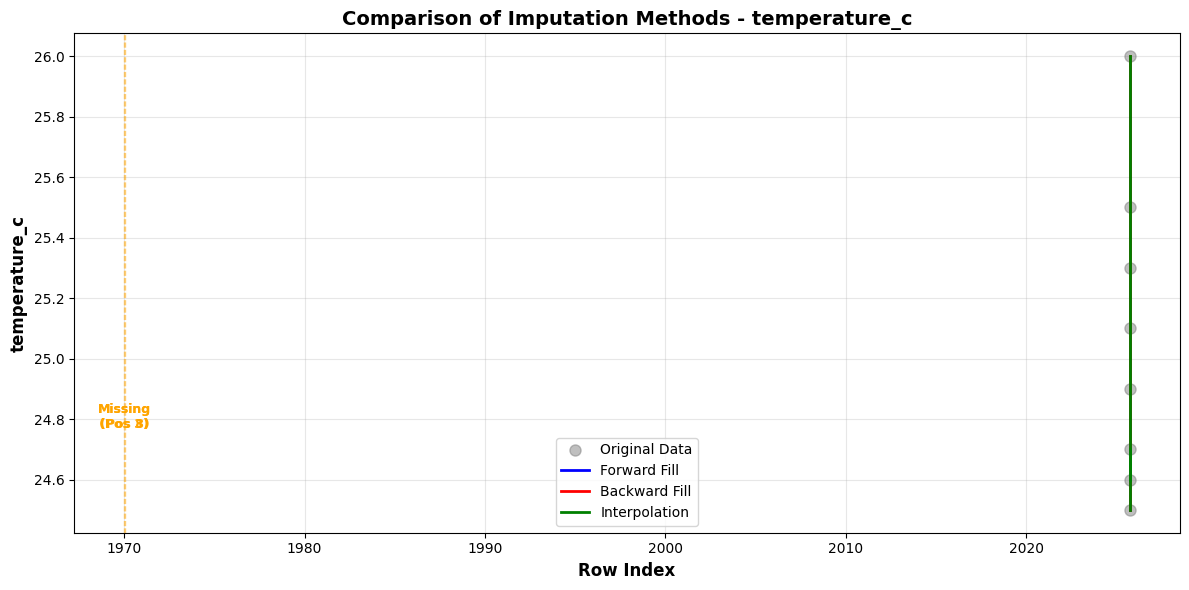

✓ Saved: comparison_temperature_c.png


C:\Users\mante\AppData\Local\Temp\ipykernel_3488\1743390613.py:106: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


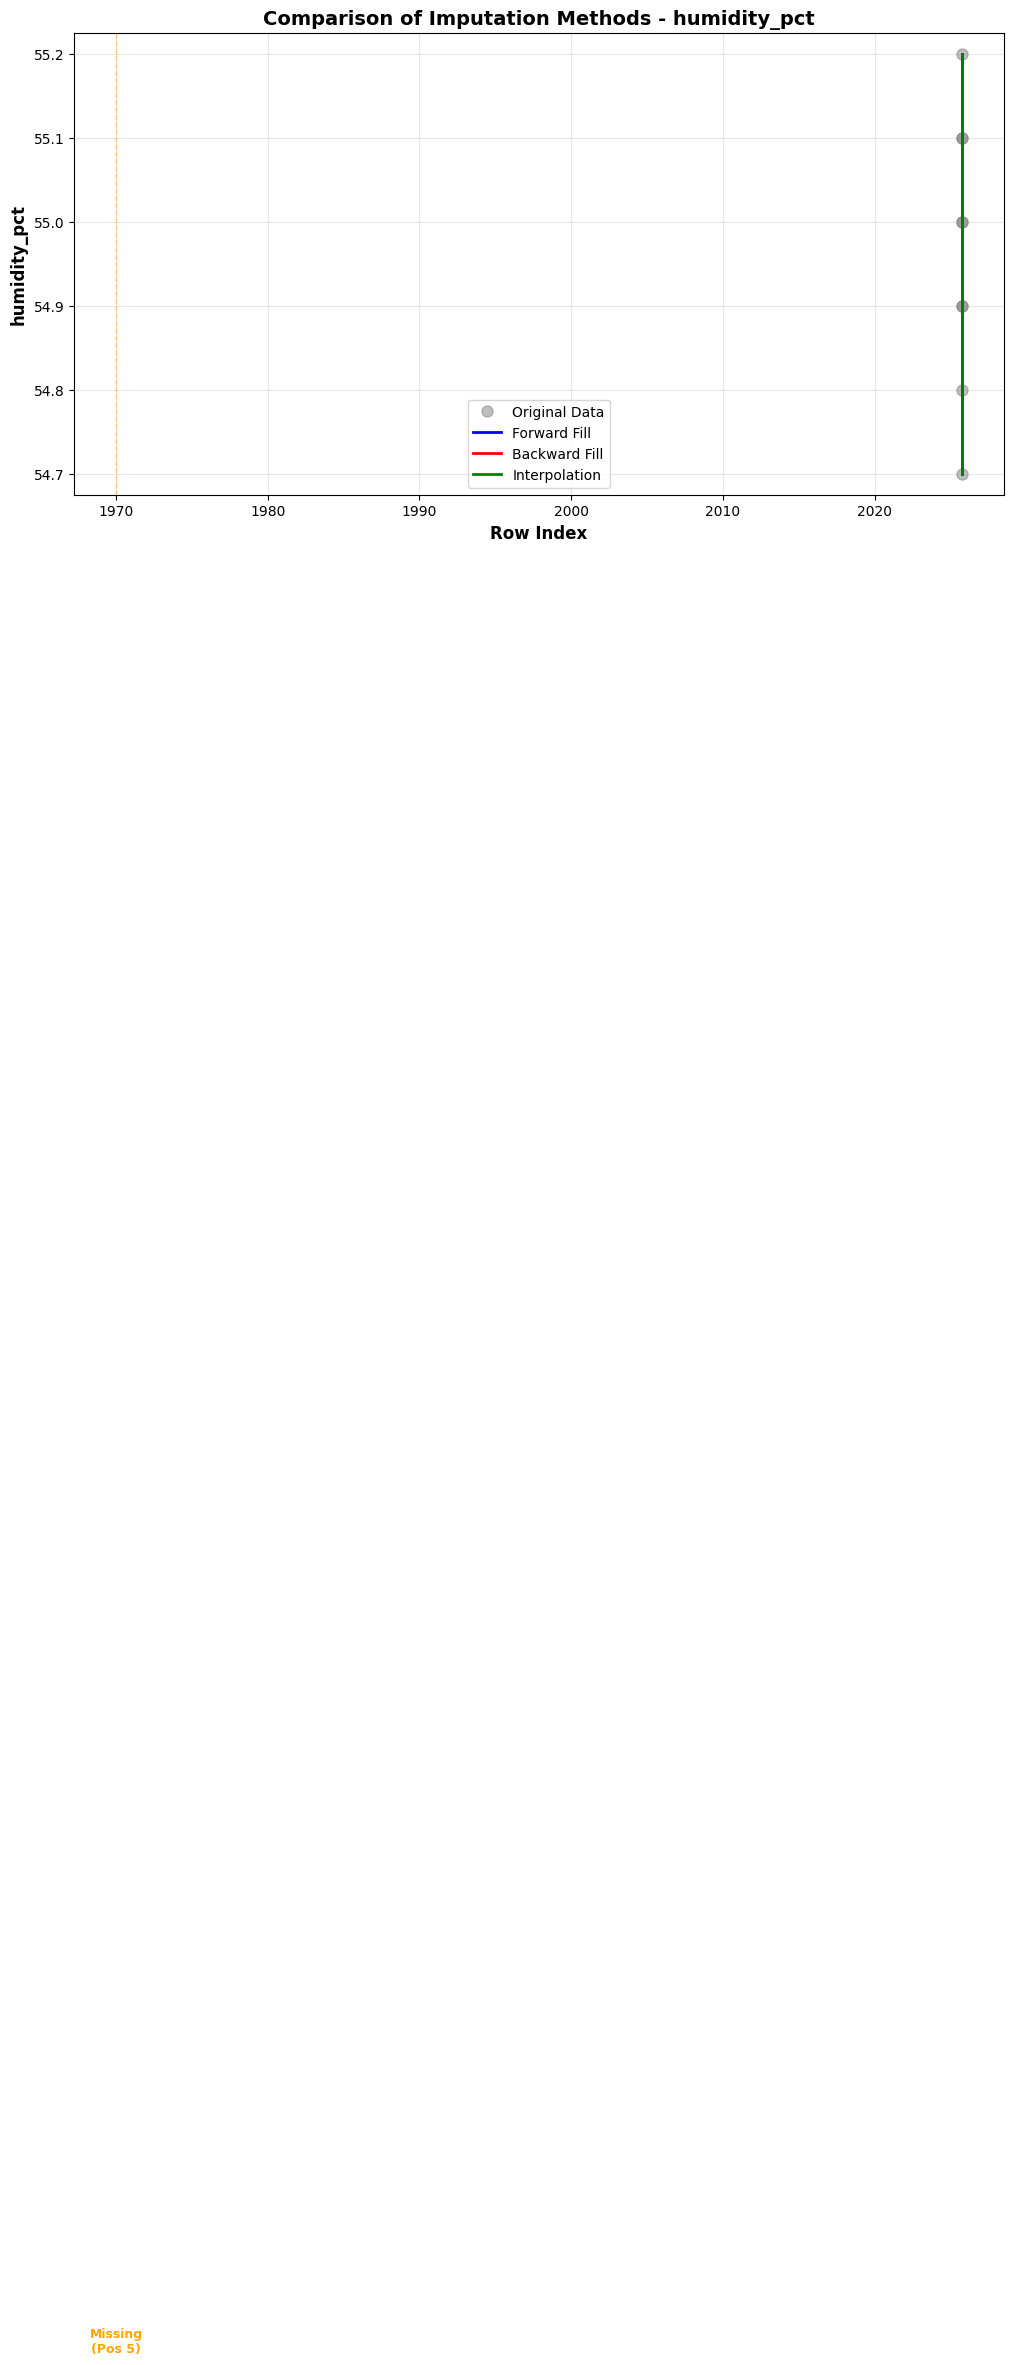

✓ Saved: comparison_humidity_pct.png


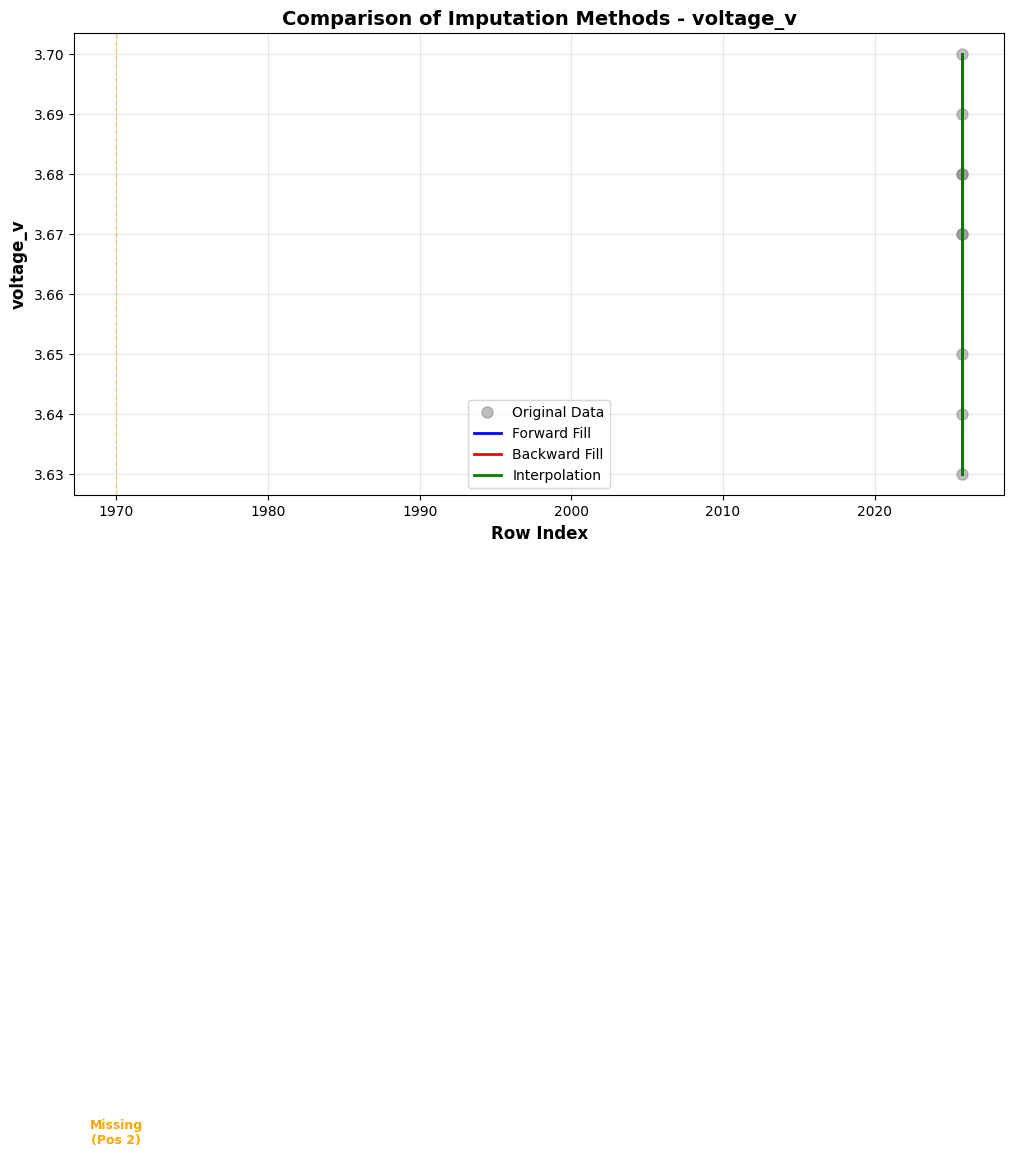

✓ Saved: comparison_voltage_v.png


In [36]:
# ============================================================================
# QUESTION 2: Compare values side by side for a small time range
# ============================================================================
print("\n" + "="*70)
print("QUESTION 2: Side-by-Side Comparison")
print("="*70)

# Get rows that originally had missing values
missing_rows_idx = df_ts[df_ts.isnull().any(axis=1)].index

if len(missing_rows_idx) > 0:
    print(f"\nFound {len(missing_rows_idx)} row(s) with missing values")
    print(f"Row positions: {missing_rows_idx.tolist()}")
    
    # For each row with missing values, show context (before and after)
    for position in missing_rows_idx:
        # Get the integer position in the dataframe
        pos = df_ts.index.get_loc(position)
        
        # Define a small range around the missing value
        start_pos = max(0, pos - 2)
        end_pos = min(len(df_ts), pos + 3)
        
        print(f"\n{'='*70}")
        print(f"COMPARISON AROUND POSITION {pos} (showing positions {start_pos} to {end_pos-1})")
        print(f"{'='*70}")
        
        # Create comparison dataframe
        comparison = pd.DataFrame({
            'Position': range(start_pos, end_pos),
            'Original': [str(df_ts.iloc[i].values) for i in range(start_pos, end_pos)],
            'Forward Fill': [str(df_ffill.iloc[i].values) for i in range(start_pos, end_pos)],
            'Backward Fill': [str(df_bfill.iloc[i].values) for i in range(start_pos, end_pos)],
            'Interpolation': [str(df_interpolate.iloc[i].values) for i in range(start_pos, end_pos)]
        })
        
        print(comparison.to_string(index=False))
        
        # Highlight the row with missing value
        print(f"\n→ Position {pos} had missing value(s) (marked above)")

# Detailed column-by-column comparison
print("\n" + "="*70)
print("DETAILED COLUMN-BY-COLUMN COMPARISON")
print("="*70)

for column in df_ts.columns:
    if df_ts[column].isnull().sum() > 0:
        print(f"\n📊 Column: {column}")
        print("-"*70)
        
        missing_positions = df_ts[df_ts[column].isnull()].index
        
        for idx in missing_positions:
            pos = df_ts.index.get_loc(idx)
            
            print(f"\nPosition {pos} (originally missing):")
            print(f"  Forward Fill:  {df_ffill.iloc[pos][column]}")
            print(f"  Backward Fill: {df_bfill.iloc[pos][column]}")
            print(f"  Interpolation: {df_interpolate.iloc[pos][column]}")
            
            # Show context
            if pos > 0:
                print(f"  Previous value (Pos {pos-1}): {df_ts.iloc[pos-1][column]}")
            if pos < len(df_ts) - 1:
                print(f"  Next value (Pos {pos+1}): {df_ts.iloc[pos+1][column]}")

# ============================================================================
# VISUALIZATION: Compare Methods
# ============================================================================
print("\n" + "="*70)
print("VISUALIZATION: Comparing Imputation Methods")
print("="*70)

numeric_cols = df_ts.select_dtypes(include=[np.number]).columns.tolist()

for column in numeric_cols:
    if df_ts[column].isnull().sum() > 0:
        plt.figure(figsize=(12, 6))
        
        # Plot all methods
        plt.plot(df_ts.index, df_ts[column], 'o', markersize=8, label='Original Data', 
                 color='gray', alpha=0.5)
        plt.plot(df_ffill.index, df_ffill[column], '-', linewidth=2, 
                 label='Forward Fill', color='blue')
        plt.plot(df_bfill.index, df_bfill[column], '-', linewidth=2, 
                 label='Backward Fill', color='red')
        plt.plot(df_interpolate.index, df_interpolate[column], '-', linewidth=2, 
                 label='Interpolation', color='green')
        
        # Mark missing value positions
        missing_idx = df_ts[df_ts[column].isnull()].index
        for idx in missing_idx:
            pos = df_ts.index.get_loc(idx)
            plt.axvline(x=pos, color='orange', linestyle='--', alpha=0.5, linewidth=1)
            plt.text(pos, plt.ylim()[1]*0.95, f'Missing\n(Pos {pos})', 
                    ha='center', fontsize=9, color='orange', fontweight='bold')
        
        plt.xlabel('Row Index', fontsize=12, fontweight='bold')
        plt.ylabel(column, fontsize=12, fontweight='bold')
        plt.title(f'Comparison of Imputation Methods - {column}', 
                 fontsize=14, fontweight='bold')
        plt.legend(loc='best', fontsize=10)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'comparison_{column}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✓ Saved: comparison_{column}.png")

In [38]:
# ============================================================================
# QUESTION 3: Discussion - Which method is most reasonable?
# ============================================================================
print("\n" + "="*70)
print("QUESTION 3: Discussion - Which Method is Most Reasonable?")
print("="*70)

print("""
 ANALYSIS OF EACH METHOD FOR SENSOR DATA:

1. FORWARD FILL (ffill):
   ✓ Pros:
     • Uses the last known value
     • Assumes sensor value hasn't changed
     • Simple and fast
     • Good when changes are slow/gradual
   
   ✗ Cons:
     • Creates "flat" segments (plateaus)
     • Ignores trend direction
     • Can be inaccurate if value is changing rapidly
     • Lags behind actual changes

2. BACKWARD FILL (bfill):
   ✓ Pros:
     • Uses the next known value
     • Can be useful for "look-ahead" scenarios
     
   ✗ Cons:
     • Creates jumps/discontinuities
     • Not physically realistic (uses future data)
     • Less intuitive for time series
     • Can't be used in real-time systems

3. INTERPOLATION (linear):
   ✓ Pros:
     • Estimates based on surrounding values
     • Creates smooth transitions
     • Captures trends between points
     • More realistic for gradually changing data
     • Better preserves data patterns
   
   ✗ Cons:
     • May not be accurate for rapid changes
     • Requires values on both sides
     • Slightly more complex computation

 RECOMMENDATION FOR SENSOR DATA:

For IoT sensor data (temperature, humidity, voltage):

 BEST CHOICE: INTERPOLATION (linear)

Reasons:
1. Sensor values typically change GRADUALLY over time
2. Temperature/humidity don't jump instantly
3. Interpolation creates SMOOTH, REALISTIC transitions
4. It considers both before and after values
5. More accurate representation of physical processes

When Forward Fill might be better:
• Very slow-changing sensors (e.g., soil moisture)
• When you need real-time predictions (can't look ahead)
• When missing values are at the end of the dataset

When to avoid Backward Fill:
• Almost never for time series sensor data
• Only useful in post-processing or specific analytical cases
""")

# Calculate statistics to support the recommendation
print("\n" + "="*70)
print("STATISTICAL COMPARISON")
print("="*70)

for column in numeric_cols:
    if df_ts[column].isnull().sum() > 0:
        print(f"\n{column}:")
        print("-"*70)
        
        # Calculate differences from surrounding values
        missing_positions = df_ts[df_ts[column].isnull()].index
        
        for idx in missing_positions:
            pos = df_ts.index.get_loc(idx)
            
            if pos > 0 and pos < len(df_ts) - 1:
                prev_val = df_ts.iloc[pos-1][column]
                next_val = df_ts.iloc[pos+1][column]
                
                ffill_val = df_ffill.iloc[pos][column]
                bfill_val = df_bfill.iloc[pos][column]
                interp_val = df_interpolate.iloc[pos][column]
                
                print(f"\n  Position {pos} (between {prev_val:.2f} and {next_val:.2f}):")
                print(f"    Forward Fill:  {ffill_val:.2f} (diff from next: {abs(ffill_val-next_val):.2f})")
                print(f"    Backward Fill: {bfill_val:.2f} (diff from prev: {abs(bfill_val-prev_val):.2f})")
                print(f"    Interpolation: {interp_val:.2f} (midpoint)")
                
                # Calculate which is closest to the average
                avg_val = (prev_val + next_val) / 2
                print(f"    Expected midpoint: {avg_val:.2f}")
                print(f"    → Interpolation error: {abs(interp_val - avg_val):.2f}")


QUESTION 3: Discussion - Which Method is Most Reasonable?

 ANALYSIS OF EACH METHOD FOR SENSOR DATA:

1. FORWARD FILL (ffill):
   ✓ Pros:
     • Uses the last known value
     • Assumes sensor value hasn't changed
     • Simple and fast
     • Good when changes are slow/gradual

   ✗ Cons:
     • Creates "flat" segments (plateaus)
     • Ignores trend direction
     • Can be inaccurate if value is changing rapidly
     • Lags behind actual changes

2. BACKWARD FILL (bfill):
   ✓ Pros:
     • Uses the next known value
     • Can be useful for "look-ahead" scenarios

   ✗ Cons:
     • Creates jumps/discontinuities
     • Not physically realistic (uses future data)
     • Less intuitive for time series
     • Can't be used in real-time systems

3. INTERPOLATION (linear):
   ✓ Pros:
     • Estimates based on surrounding values
     • Creates smooth transitions
     • Captures trends between points
     • More realistic for gradually changing data
     • Better preserves data patterns

   

## 6. Putting it all together: choosing a strategy

There is no single "best" way to handle missing values. The right choice depends on:

- **How much data is missing**: a few values or a large portion of the dataset.
- **Why the data is missing**: at random, due to sensor failure, due to human choices, and so on.
- **How the data will be used**: simple descriptive statistics, predictive models, control systems, etc.

Typical workflow:
1. Explore the data and understand where and how much is missing.
2. Try simple strategies such as dropping rows or filling with mean/median for numeric values.
3. For time series, consider forward fill, backward fill, or interpolation.
4. Check how your results change when you use different strategies.

As you advance in your studies, you will learn more advanced imputation methods (for example, using machine learning models to predict missing values).


## 7. Final practice (mini project)

As a final exercise, work through the following steps on your own copy of the dataset:

1. Load `sensor_log.csv` into a new DataFrame.
2. Summarise missing values per column (counts and percentages).
3. Decide, with justification, which columns or rows (if any) you would drop.
4. Choose and apply an imputation strategy for the remaining missing values (for example, mean/median or forward fill).
5. Compare key summary statistics (mean, min, max) before and after imputation.
6. Write a short paragraph explaining which decisions you made and why they are reasonable for this dataset.

This type of reasoning is a crucial skill for any data analyst.
